In this notebook, we'll focus on tree-based models. We will begin with a Random Forest model to leverage many different decision trees, and then explore two boosting algorithms, AdaBoost and Gradient Boosting. Like previously, we will compare default models to tuned models, and analyze feature importances. We will also visualize the trade-offs associated with the number of trees (n_estimators)

Let's reimport the libraries we'll need, and load our data one more time. We'll also have to perform another train-test split and perform preprocessing on the data to make sure it's normalized.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("cardio_data_clean.csv")

df = pd.get_dummies(df, drop_first=True)

%run model_utils.ipynb
df = bool_to_int(df)

df = df.drop('age_years', axis=1)

In [3]:
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
scale_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']

ct = ColumnTransformer(transformers=[('scale', StandardScaler(), scale_cols)], remainder='passthrough')

X_train_transform = ct.fit_transform(X_train)
X_test_transform = ct.transform(X_test)

In [5]:
scaled_cols = scale_cols
other_cols = [col for col in X.columns if col not in scale_cols]
all_cols = scaled_cols + other_cols

X_train = pd.DataFrame(X_train_transform, columns=all_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_transform, columns=all_cols, index=X_test.index)

We will begin our exploration of tree-based modeling with the Random Forest model. As with previous models, we will evaluate performance both before and after hyperparameter tuning to better understand the model's behavior. Additionally, we will analysze how increasing the number of trees impacts generalization, training time, and potential overfitting.

# Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, f1_score, recall_score
import pickle

In [91]:
rfc = RandomForestClassifier(random_state=42)

In [92]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

It seems that age is overwhelmingly the largest predictor in determining the possibility of cardiovascular disease for this model. The features that follow: ap_lo, weight, height, and gender indicates that physical and demographic factors play a larger role in this model's decision-making process rather than lifestyle indicators like smoking, consuming alcohol, or activity level.

In [93]:
rfc_pred = rfc.predict(X_test)

In [94]:
accuracy_score(y_test, rfc_pred)

0.6954997554214903

In [95]:
confusion_matrix(y_test, rfc_pred)

array([[4446, 1808],
       [1927, 4085]], dtype=int64)

In [96]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6254
           1       0.69      0.68      0.69      6012

    accuracy                           0.70     12266
   macro avg       0.70      0.70      0.70     12266
weighted avg       0.70      0.70      0.70     12266



In [97]:
export_model_results(y_test, rfc_pred, 'Random Forest (Untuned)', 'model_results/random_forest.pkl')

We will visualize the feature importances in a cleaner format, as this will help us interpret which factors it considers to be the most influential when making predictions.

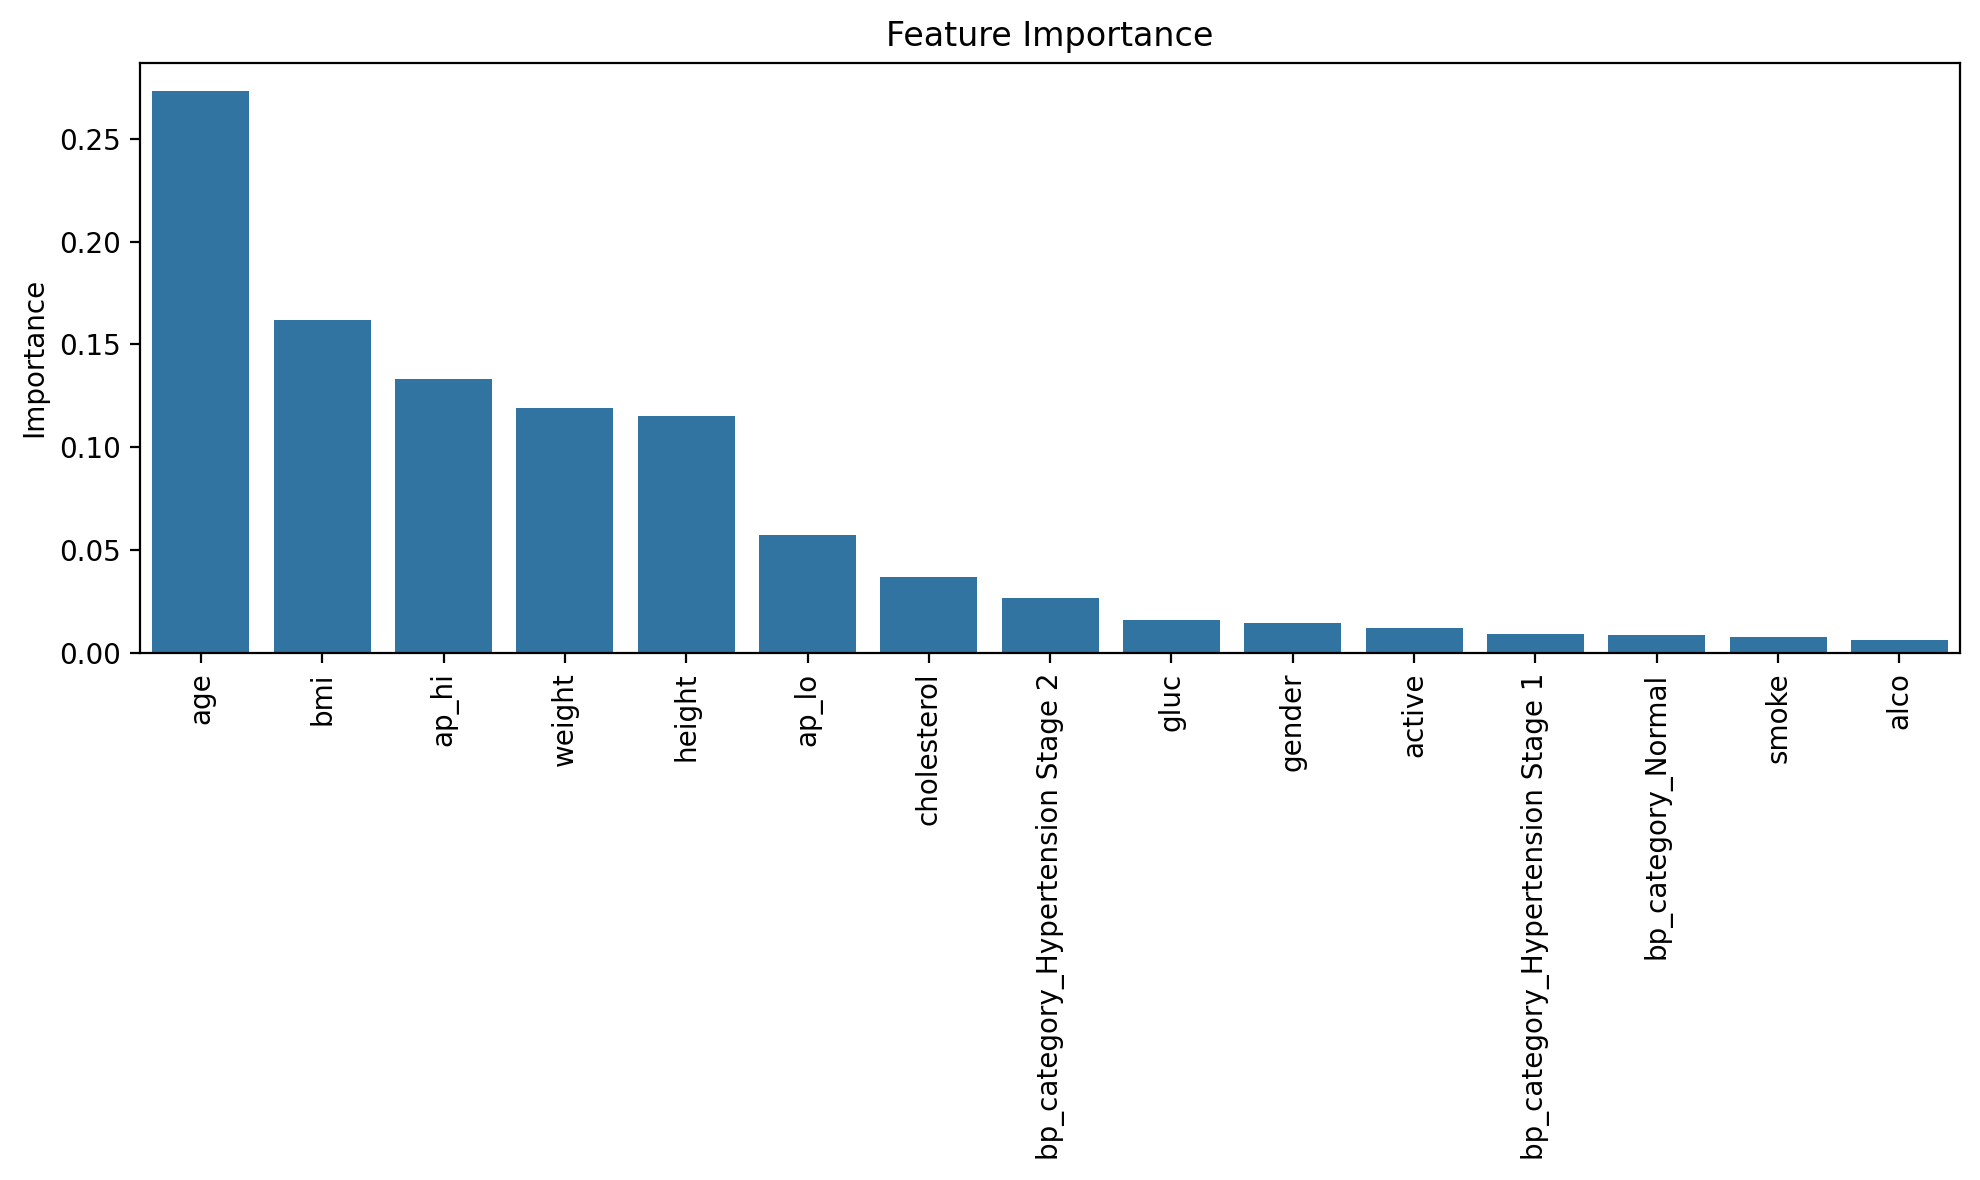

In [98]:
plot_tree_feature_importance(rfc, X_train.columns)

Wee see that physical measurements are prioritized by the model. The model indicates that age is by far the most influential feature in predicting cardiovascular disease, which is followed by bmi, ap_hi, weight, and height. Behavioral features like activity, smoking, and alcohol contributed relatively little, which might suggest they don't have strong predictive value in this specific dataset, or their effects are captured indirectly through other features like BMI or blood pressure.

Let's save the base model's feature importances before we move on.

In [99]:
export_tree_feature_importances(rfc, X_train.columns, "random_forest")

Just as we did with previous models, we'll use GridSearchCV to tune hyperparameters for Gradient Boosting. We'll define a targeted parameter grid to evaluate whether fine-tuning leads to any meaningful performance improvements.

In [100]:
from sklearn.model_selection import GridSearchCV

In [101]:
rfc = RandomForestClassifier()

In [102]:
rfc_param_grid = {'n_estimators':[100, 128, 200], 
              'max_features':['sqrt', 'log2'], 
              'max_depth': [10, 20, 30]}

In [103]:
rfc_grid = GridSearchCV(rfc, param_grid=rfc_param_grid, cv=5, scoring='accuracy', n_jobs=-2, verbose=2)

In [104]:
rfc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 128, 200]},
             scoring='accuracy', verbose=2)

In [105]:
rfc_grid.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 128}

In [106]:
rfc_grid_pred = rfc_grid.predict(X_test)

In [107]:
accuracy_score(y_test, rfc_grid_pred)

0.7272134355127996

In [108]:
confusion_matrix(y_test, rfc_grid_pred)

array([[4922, 1332],
       [2014, 3998]], dtype=int64)

In [109]:
print(classification_report(y_test, rfc_grid_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6254
           1       0.75      0.67      0.70      6012

    accuracy                           0.73     12266
   macro avg       0.73      0.73      0.73     12266
weighted avg       0.73      0.73      0.73     12266



In [27]:
model_results = {
    'model': 'Random Forest (Tuned)',
    'accuracy': accuracy_score(y_test, rfc_grid_pred),
    'precision': precision_score(y_test, rfc_grid_pred),
    'recall': recall_score(y_test, rfc_grid_pred),
    'f1_score': f1_score(y_test, rfc_grid_pred),
}

with open('model_results/random_forest_tuned.pkl', 'wb') as f:
    pickle.dump(model_results, f)

In [110]:
export_model_results(y_test, rfc_grid_pred,'Random Forest (Tuned)', 'model_results/random_forest_tuned.pkl')

After using GridSearchCV, there was an improvement in the accuracy score by around 3.2%, suggesting that hyperparameter optimization contributed to a more effective model fit. Let's see if this resulted in any changes to feature importances.

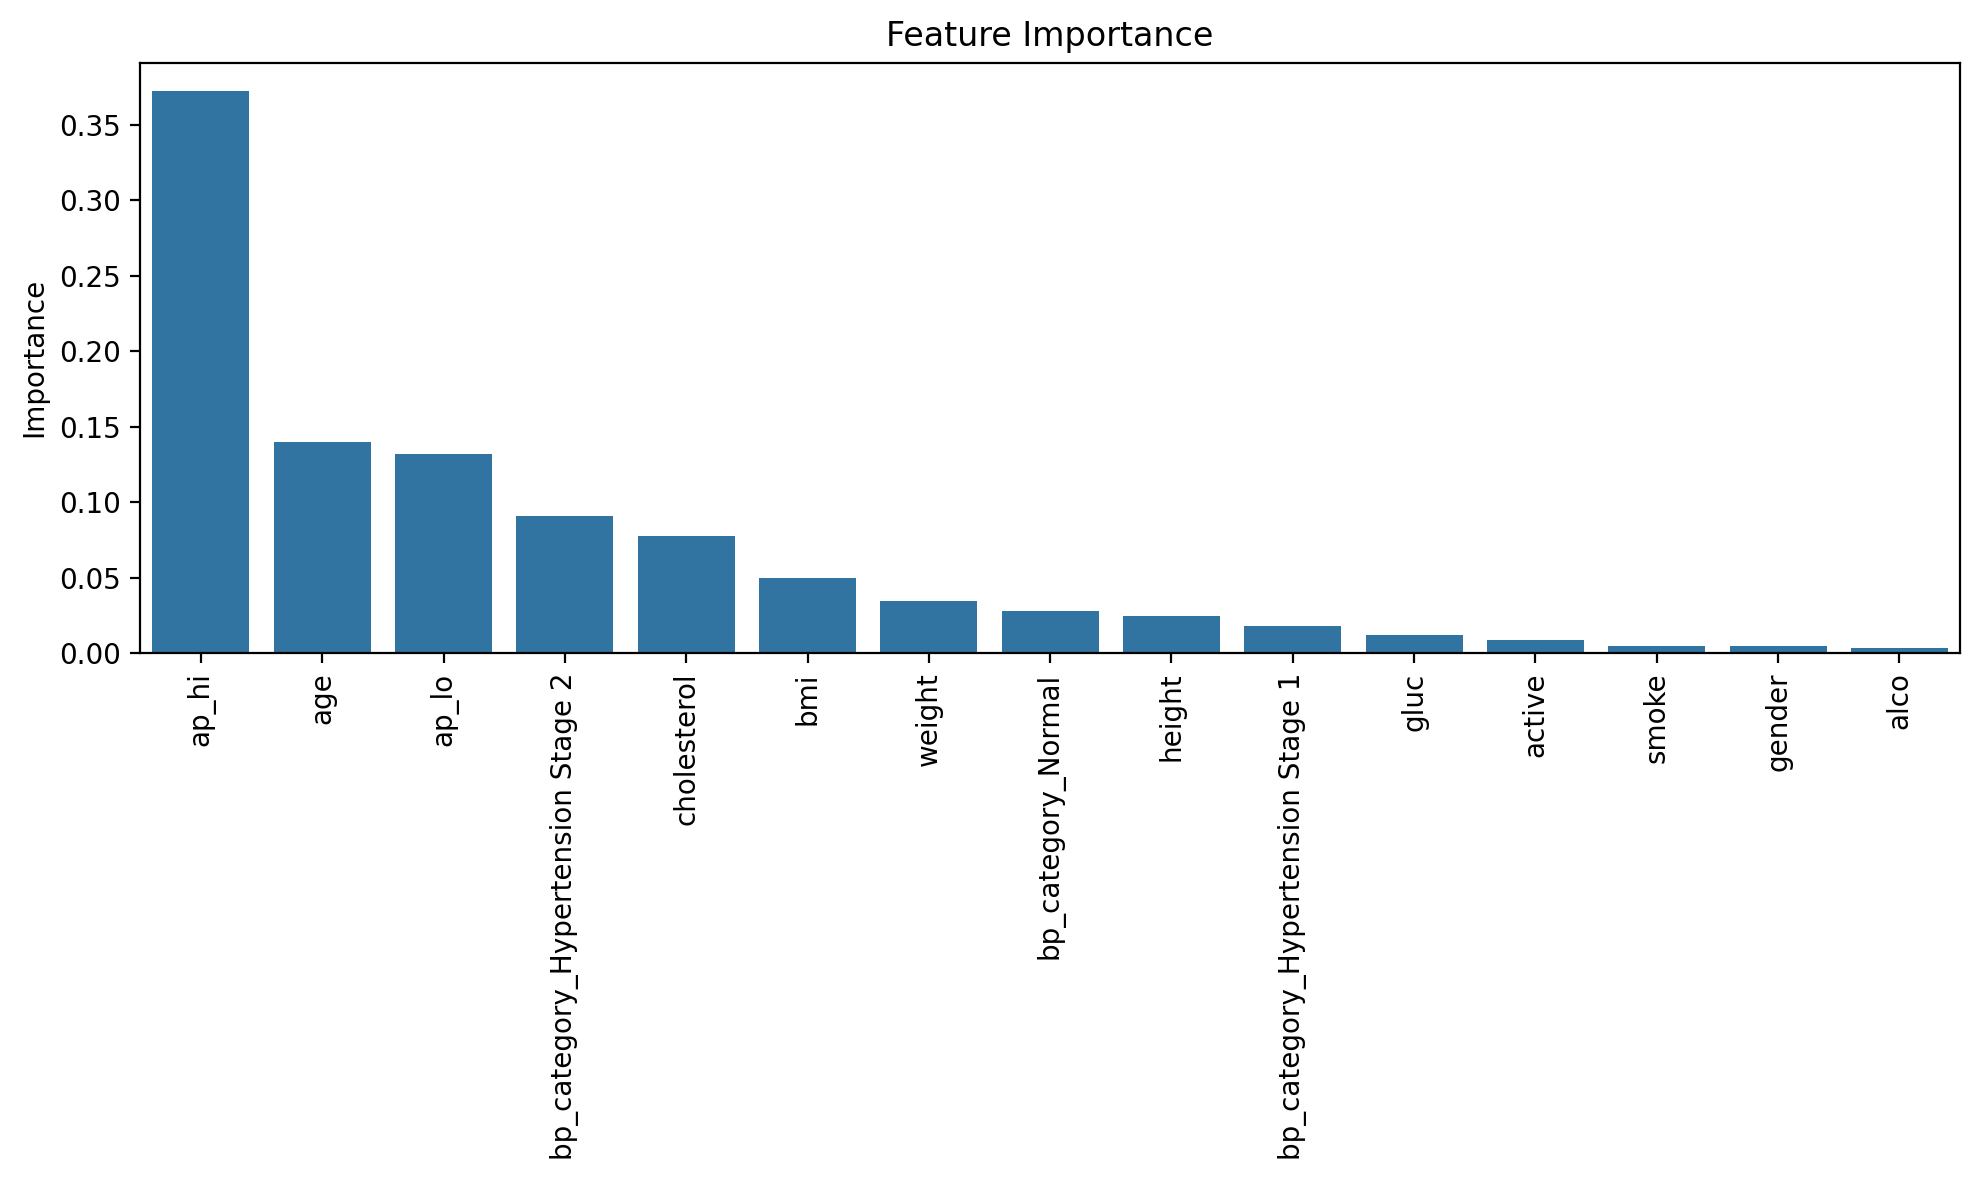

In [111]:
plot_tree_feature_importance(rfc_grid.best_estimator_, X_train.columns)

After hyperparameter tuning, the model's interpretation of feature importances shifted greatly. ap_hi has now become the model's most dominant predictor, with its importance more than doubling after tuning. age and ap_lo follow, but are still less than half as influential, and have dropped slightly in relative importance. The bottom tier of features such as smoke, gender, and alco have stayed relatively unchanged and continue to contribute very little to the model's decision making.

Let's go ahead and save the tuned model's feature importances.

In [112]:
export_tree_feature_importances(rfc_grid.best_estimator_, X_train.columns, "random_forest_tuned")

Let's take a closer look at the n_estimators parameter and how it influences model performance for a better idea of the trade-off between the model's complexity and predictive power. 

We'll keep all hyperparameters the same as the ones chosen by GridSearchCV, except for n_estimators. We will only vary n_estimators.

In [28]:
rfc_estimator_error_rates = []

for n in range(10, 210, 10):
    test_model = RandomForestClassifier(n_estimators=n, max_features='sqrt', max_depth=10, random_state=42)
    test_model.fit(X_train, y_train)
    test_preds = test_model.predict(X_test)
    rfc_estimator_error_rates.append(1 - accuracy_score(y_test, test_preds))

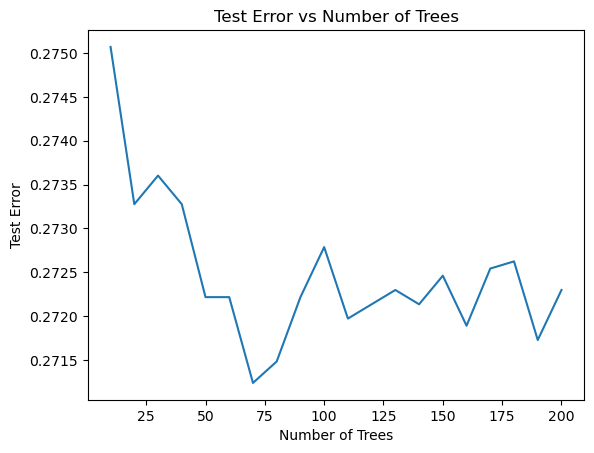

In [29]:
plt.plot(range(10, 210, 10), rfc_estimator_error_rates, label='Test Error')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.title('Test Error vs Number of Trees');

We see that initially, increasing the number of trees reduces test error, especially up to around 60-70 trees. After that, performance starts to taper off, with many diminishing returns. We see that after 100 trees, the test error starts to fluctuate, but remains relatively stable compared to the rest of the values. There isn't exactly a sharp increase in test error as we add more trees, but using more than 100-120 trees offers minimal accuracy improvement, and even reductions in performance in some cases. 

Now that we've explored how Random Forests perform on this dataset, inlcuding how performance scales with varying numbers of trees, we will move onto Boosted Tree models. We'll look at both AdaBoost and Gradient Boosting, training them with default parameters, tuning with GridSearchCV, and evaluating their accuracy. We'll also plot test error over boosting rounds and analyze feature importance.

# Boosted Trees

AdaBoost builds an ensemble of shallow trees, or weak learners, sequentially with each tree trying to fix the mistakes of the previous one. Gradient Boosting builds trees sequentially to optimize performance with a focus on residual errors. 

## AdaBoost

In [113]:
from sklearn.ensemble import AdaBoostClassifier

In [114]:
ada = AdaBoostClassifier(algorithm='SAMME')
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME')

In [115]:
ada_pred = ada.predict(X_test)

In [116]:
accuracy_score(y_test, ada_pred)

0.7194684493722485

In [117]:
confusion_matrix(y_test, ada_pred)

array([[5018, 1236],
       [2205, 3807]], dtype=int64)

In [118]:
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      6254
           1       0.75      0.63      0.69      6012

    accuracy                           0.72     12266
   macro avg       0.72      0.72      0.72     12266
weighted avg       0.72      0.72      0.72     12266



In [120]:
export_model_results(y_test, ada_pred, 'AdaBoost (Untuned)', 'model_results/adaboost.pkl')

Now that we've trained the AdaBoost model with default hyperparameters, let's examine which single feature it relied on the most when making predictions, using the .feature_importances_.argmax() call. Using this, we can pinpoint which feature the model believes to be the single most influential feature in identifying whether or not a patient is likely to have cardiovascular disease.

In [37]:
ada.feature_importances_.argmax()

3

In [38]:
X.columns[3]

'weight'

<Axes: xlabel='weight', ylabel='Density'>

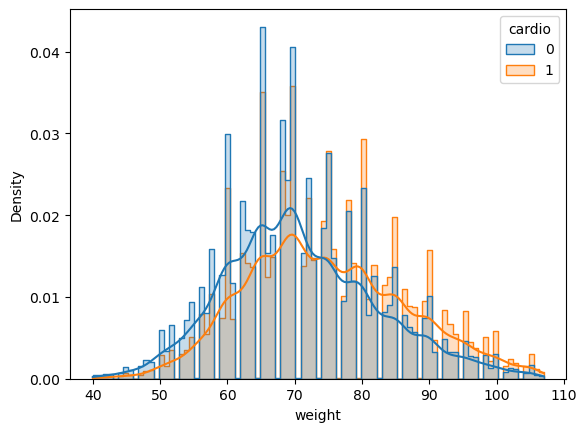

In [39]:
sns.histplot(data=df, x='weight', hue='cardio', kde=True, element='step', stat='density')

Despite there being significant overlap in the weight ranges for both classes, people without cardiovascular disease (blue) tend to be slightly lighter, with a density curve peaking earlier (around 65-70 kg) and tapering off. Let's take a closer look at which features matter overall by analyzing the feature importances, like with other models.

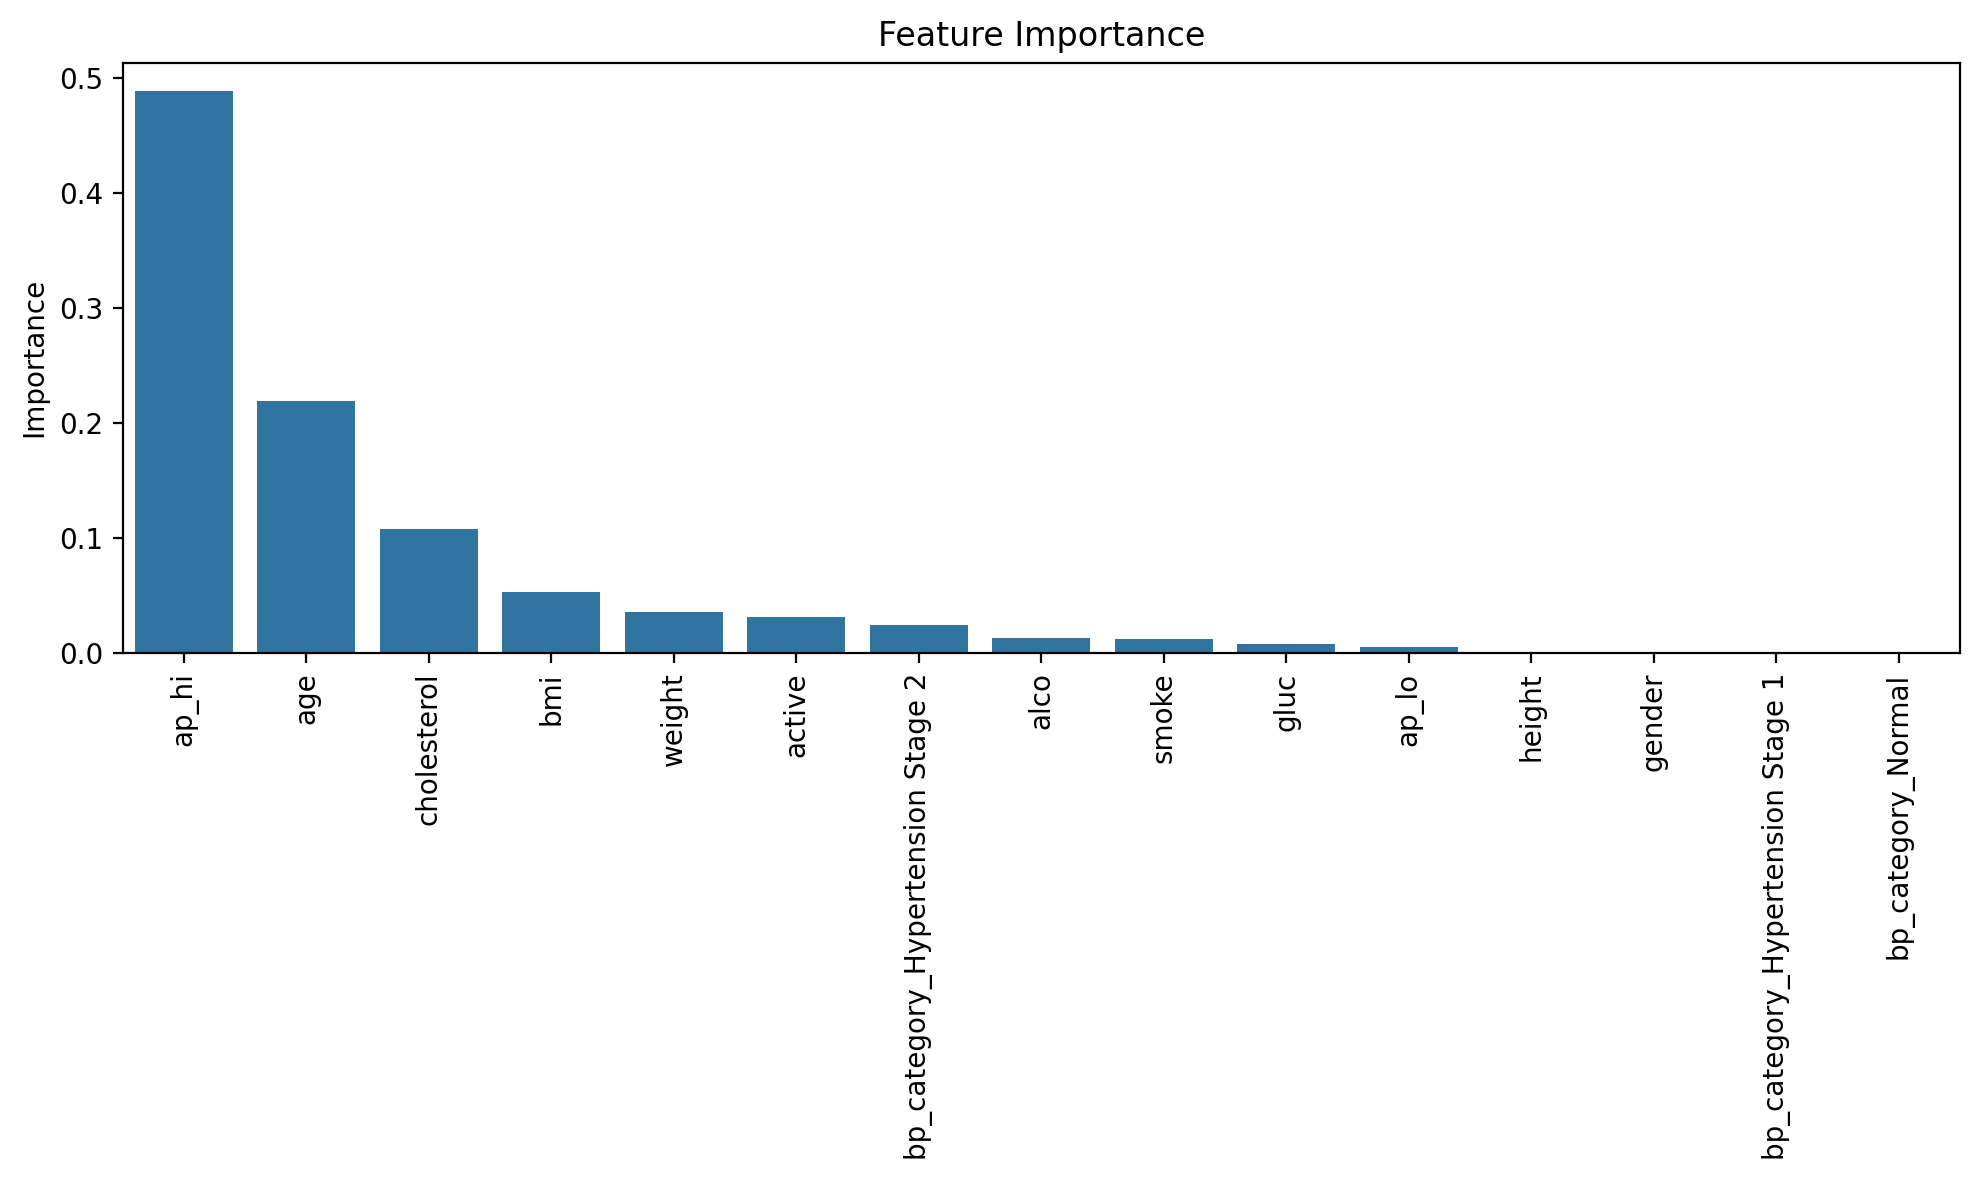

In [121]:
plot_tree_feature_importance(ada, X_train.columns)

ap_hi is again by far the most important feature, with nearly 50% of the model's total importance. Age follows with about half as the importance. Again, features such as alco, smoke, and gluc show very minor importance. What's interesting is that features such as height, and bp_category have virtually no impact in the model's current configuration.

Let's save the untuned model's feature importances.

In [122]:
export_tree_feature_importances(ada, X_train.columns, "adaboost")

Now that we've identified which features have the most predictive power, let's tune our AdaBoost model using GridSearchCV and also explore how the number of boosting rounds affects its performance. We'll only be searching for the best learning_rate hyperparameter, as we'll be taking a closer look at the effects of n_estimators afterwards.

In [123]:
ada = AdaBoostClassifier(algorithm='SAMME')

In [124]:
ada_param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}

In [125]:
ada_grid = GridSearchCV(ada, param_grid=ada_param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [126]:
ada_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=-2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]},
             scoring='accuracy')

A learning rate of 1 means each tree has a large influence on the next. It trains faster but it can risk overfitting. Let's plot the test error vs the number of estimators using this learning rate of 1 so we can visually check if performance degrades or fluctuates.

In [127]:
len(X.columns)

15

In [128]:
ada_estimator_error_rates = []

for n in range(1, 16):
    ada_test = AdaBoostClassifier(n_estimators=n, learning_rate=1, algorithm='SAMME')
    ada_test.fit(X_train, y_train)
    ada_test_preds = ada_test.predict(X_test)
    errors = 1 - accuracy_score(y_test, ada_test_preds)
    ada_estimator_error_rates.append(errors)

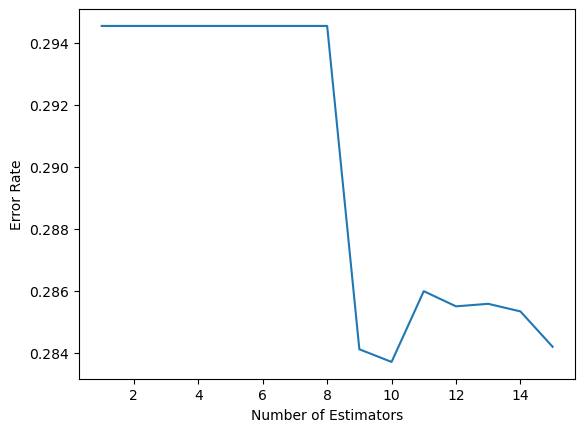

In [129]:
plt.plot(range(1,16),ada_estimator_error_rates)
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate');

Below 9 estimators, we see that the model underfits to our data, as the error is relatively flat and high. Beyond 10 estimators, we see slight fluctuation, but no significant improvement. It's best to stick with 10 estimators for this model as it gives us the best trade-off between performance and generalization. 

Let's evaluate the model's performance with 10 estimators.

In [130]:
ada_tuned = AdaBoostClassifier(learning_rate=1.0, n_estimators=10, algorithm='SAMME')

In [131]:
ada_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=10)

In [132]:
ada_tuned_pred = ada_tuned.predict(X_test)

In [133]:
accuracy_score(y_test, ada_tuned_pred)

0.7162889287461275

In [134]:
confusion_matrix(y_test, ada_tuned_pred)

array([[4975, 1279],
       [2201, 3811]], dtype=int64)

In [135]:
print(classification_report(y_test, ada_tuned_pred))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      6254
           1       0.75      0.63      0.69      6012

    accuracy                           0.72     12266
   macro avg       0.72      0.71      0.71     12266
weighted avg       0.72      0.72      0.71     12266



In [136]:
export_model_results(y_test, ada_tuned_pred, 'AdaBoost (Tuned)', 'model_results/adaboost_tuned.pkl')

Before we move on, we'll take another look at the AdaBoost model's feature importances, now after tuning hyperparameters.

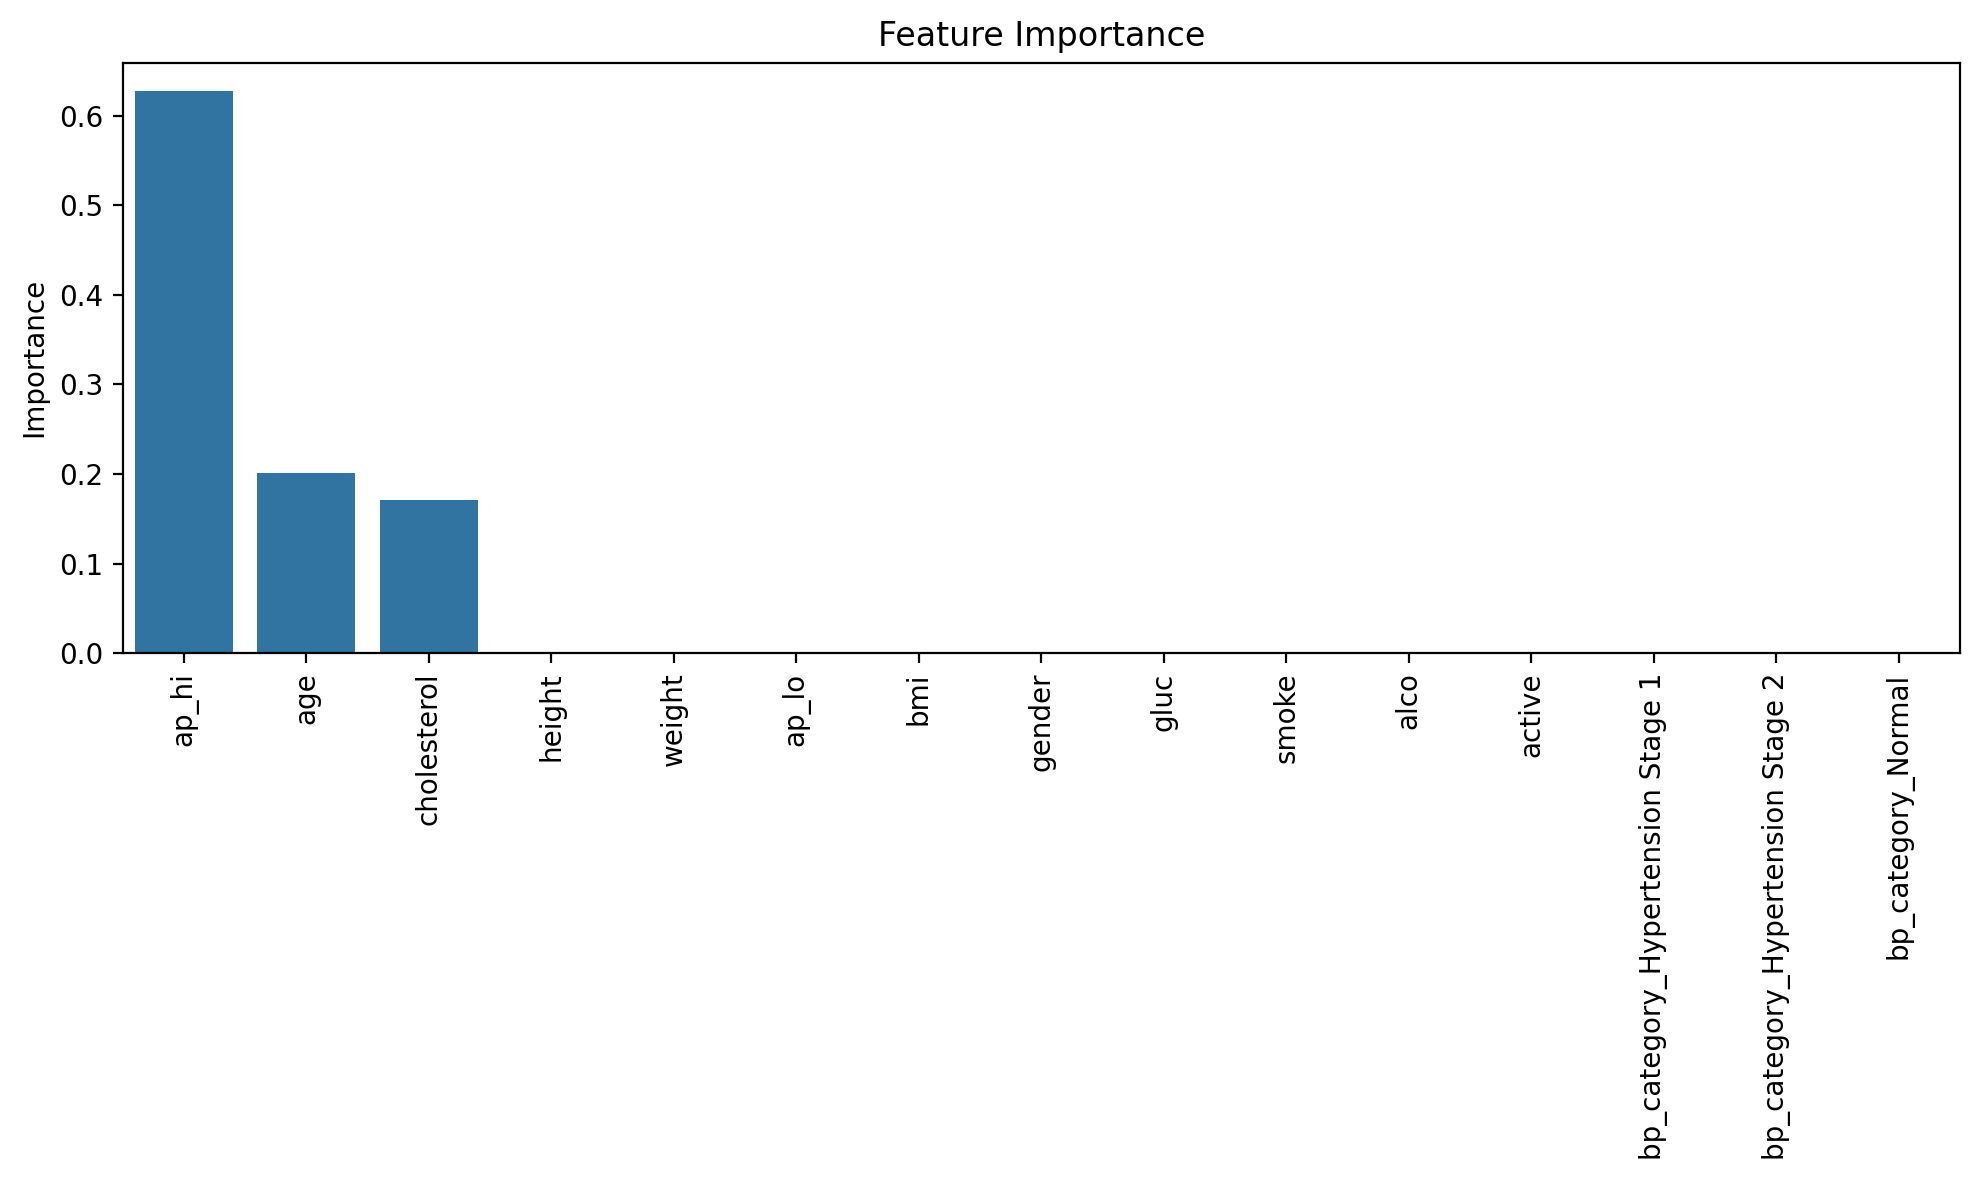

In [137]:
plot_tree_feature_importance(ada_tuned, X_train.columns)

After tuning, the AdaBoost model continues to prioritize the same top features, but now to an extreme extent. ap_hi now contributes over 60% of the model's importance. age and cholesterol follow as second and third most important features, but now all other features contribute virtually nothing to the model's predictions. It's interesting to see how hyperparameter tuning has made the AdaBoost model much more selective. This can improve performance but it also introduces the risk of overrelying on just these 3 variables, and potentially overlooking important information in less dominant variables.

Let's save the tuned model's feature importances before moving on.

In [138]:
export_tree_feature_importances(ada_tuned, X_train.columns, "adaboost_tuned")

Now we can move on to Gradient Boosting.

## Gradient Boosting

In [139]:
from sklearn.ensemble import GradientBoostingClassifier

In [140]:
gbc = GradientBoostingClassifier()

In [141]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [142]:
gbc_pred = gbc.predict(X_test)

In [143]:
accuracy_score(y_test, gbc_pred)

0.7276210663623023

In [144]:
confusion_matrix(y_test, gbc_pred)

array([[4820, 1434],
       [1907, 4105]], dtype=int64)

In [145]:
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6254
           1       0.74      0.68      0.71      6012

    accuracy                           0.73     12266
   macro avg       0.73      0.73      0.73     12266
weighted avg       0.73      0.73      0.73     12266



In [146]:
export_model_results(y_test, gbc_pred, 'Gradient Boosting (Untuned)', 'model_results/gradient_boosting.pkl')

Let's analyze the untuned model's feature importances.

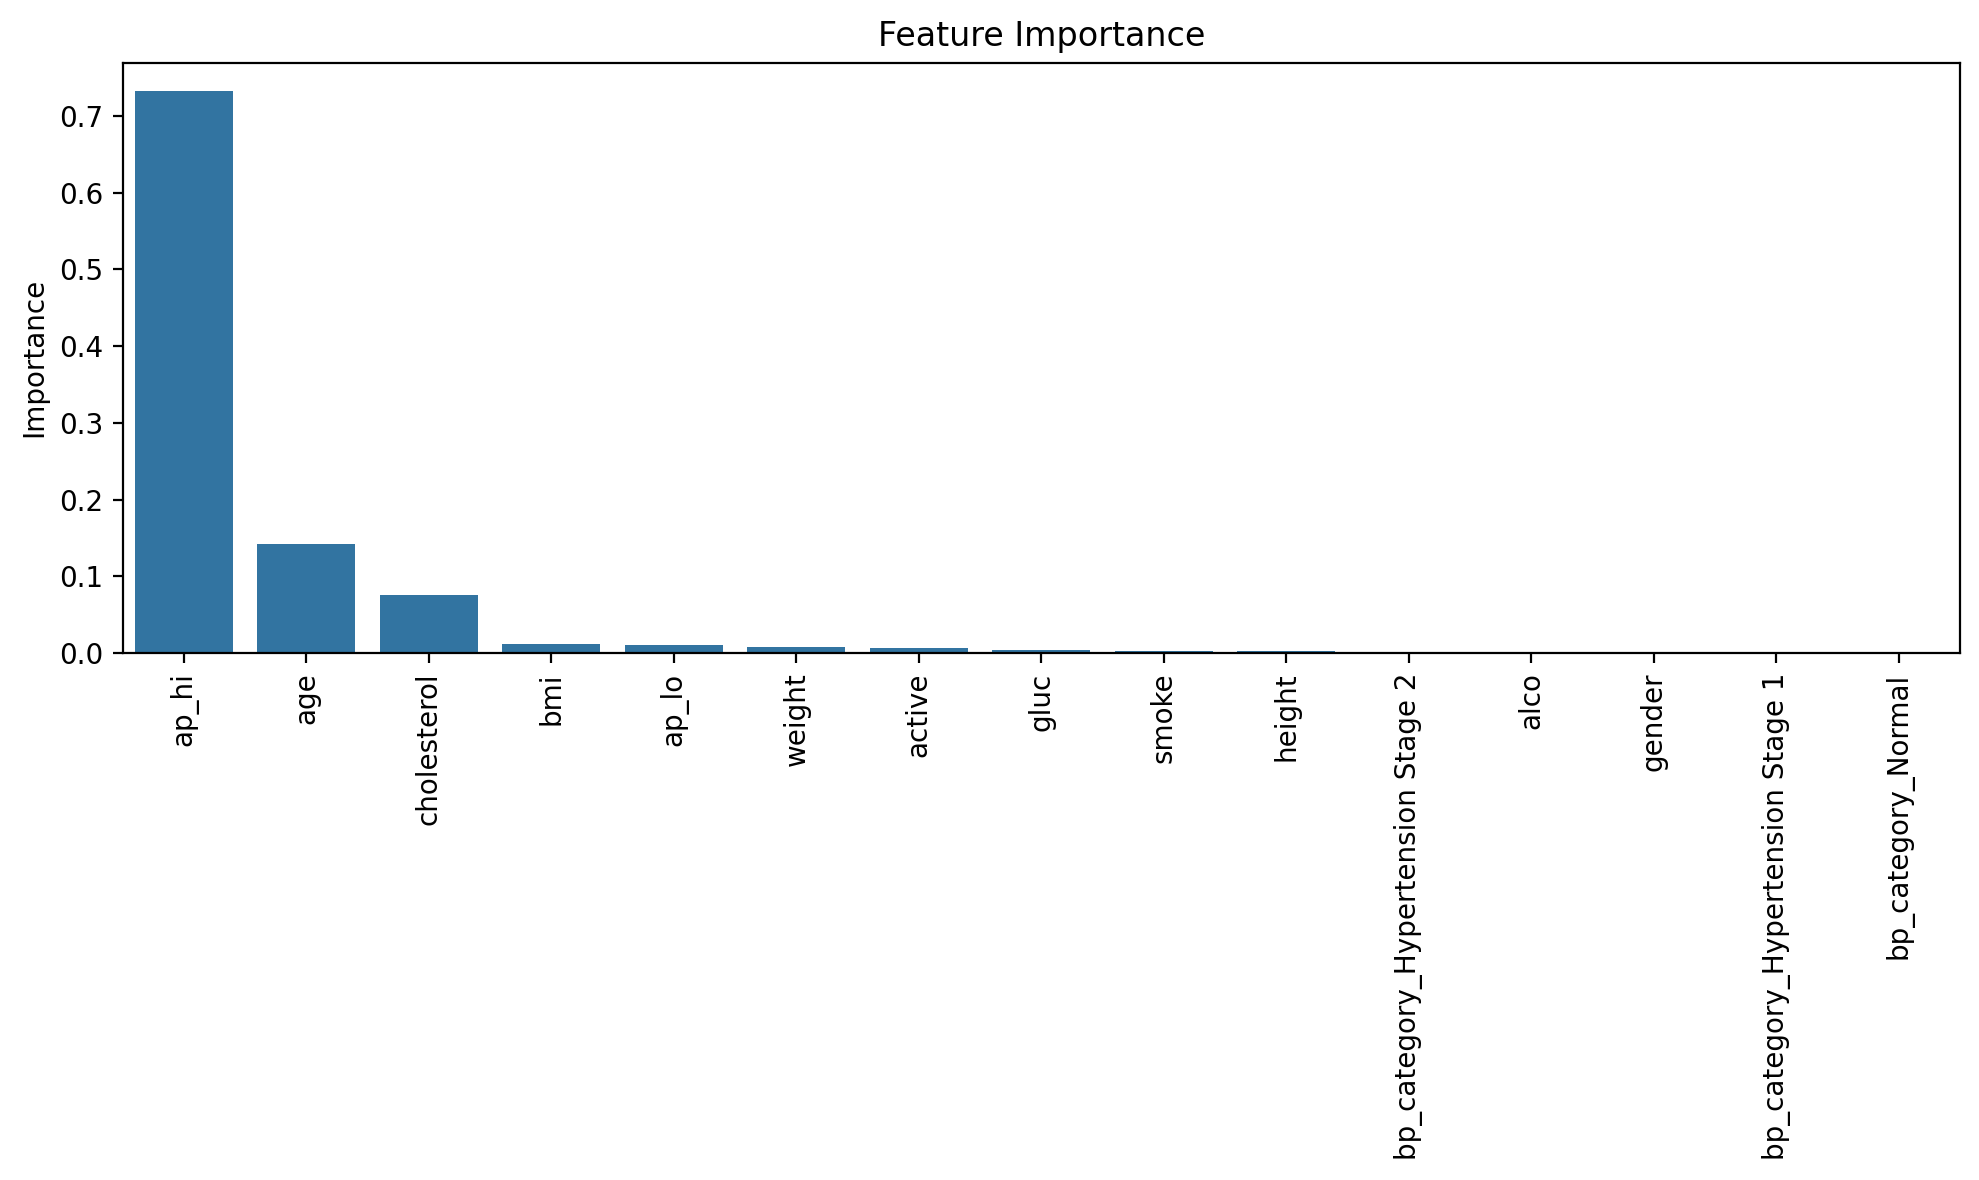

In [148]:
plot_tree_feature_importance(gbc, X_train.columns)

The untuned model reveals a strong dependency on a small number of key features, but to a less extreme extent compared to the tuned AdaBoost model. ap_hi continues to dominate, contributing over 70% of the total importance score. We also see age and cholesterol follow as the next most influential features, but are much lower compared to ap_hi. The remaining features contribute very little, but not quite as insignificant as the tuned AdaBoost model. 

Let's see if tuning redistributes some of the importance to some other relevant features. First let's save the untuned model's feature importances.

In [149]:
export_tree_feature_importances(gbc, X_train.columns, 'gradient_boosting')

Now that we've tested our Gradient Boosting model with default parameters, we'll see if we can improve our results by tuning the hyperparameters. Afterwards, we'll take a look at the feature importances and compare them to those from the AdaBoost model. This will give us some insight into how the two boosting approaches prioritize features differently in the scope of this dataset.

In [150]:
gbc = GradientBoostingClassifier()

In [151]:
gbc_param_grid = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 3, 4, 5]}

In [152]:
gbc_grid = GridSearchCV(gbc, param_grid=gbc_param_grid, cv=5, n_jobs=-2, verbose=2)

In [153]:
gbc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             verbose=2)

In [155]:
gbc_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}

In [156]:
gbc_grid_pred = gbc_grid.predict(X_test)

In [157]:
accuracy_score(y_test, gbc_grid_pred)

0.7277025925322028

In [158]:
confusion_matrix(y_test, gbc_grid_pred)

array([[4825, 1429],
       [1911, 4101]], dtype=int64)

In [159]:
print(classification_report(y_test, gbc_grid_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6254
           1       0.74      0.68      0.71      6012

    accuracy                           0.73     12266
   macro avg       0.73      0.73      0.73     12266
weighted avg       0.73      0.73      0.73     12266



In [160]:
export_model_results(y_test, gbc_grid_pred, 'Gradient Boosting (Tuned)', 'model_results/gradient_boosting_tuned.pkl')

Even after performing a grid search, the optimized parameters only resulted in negligible performance improvement. It seems that the model is already performign near its capacity. To be sure, let's explore the feature importances derived from the model, as well as visualize differences in changing the number of estimators and its impact on model error, like we did with our Random Forest model.

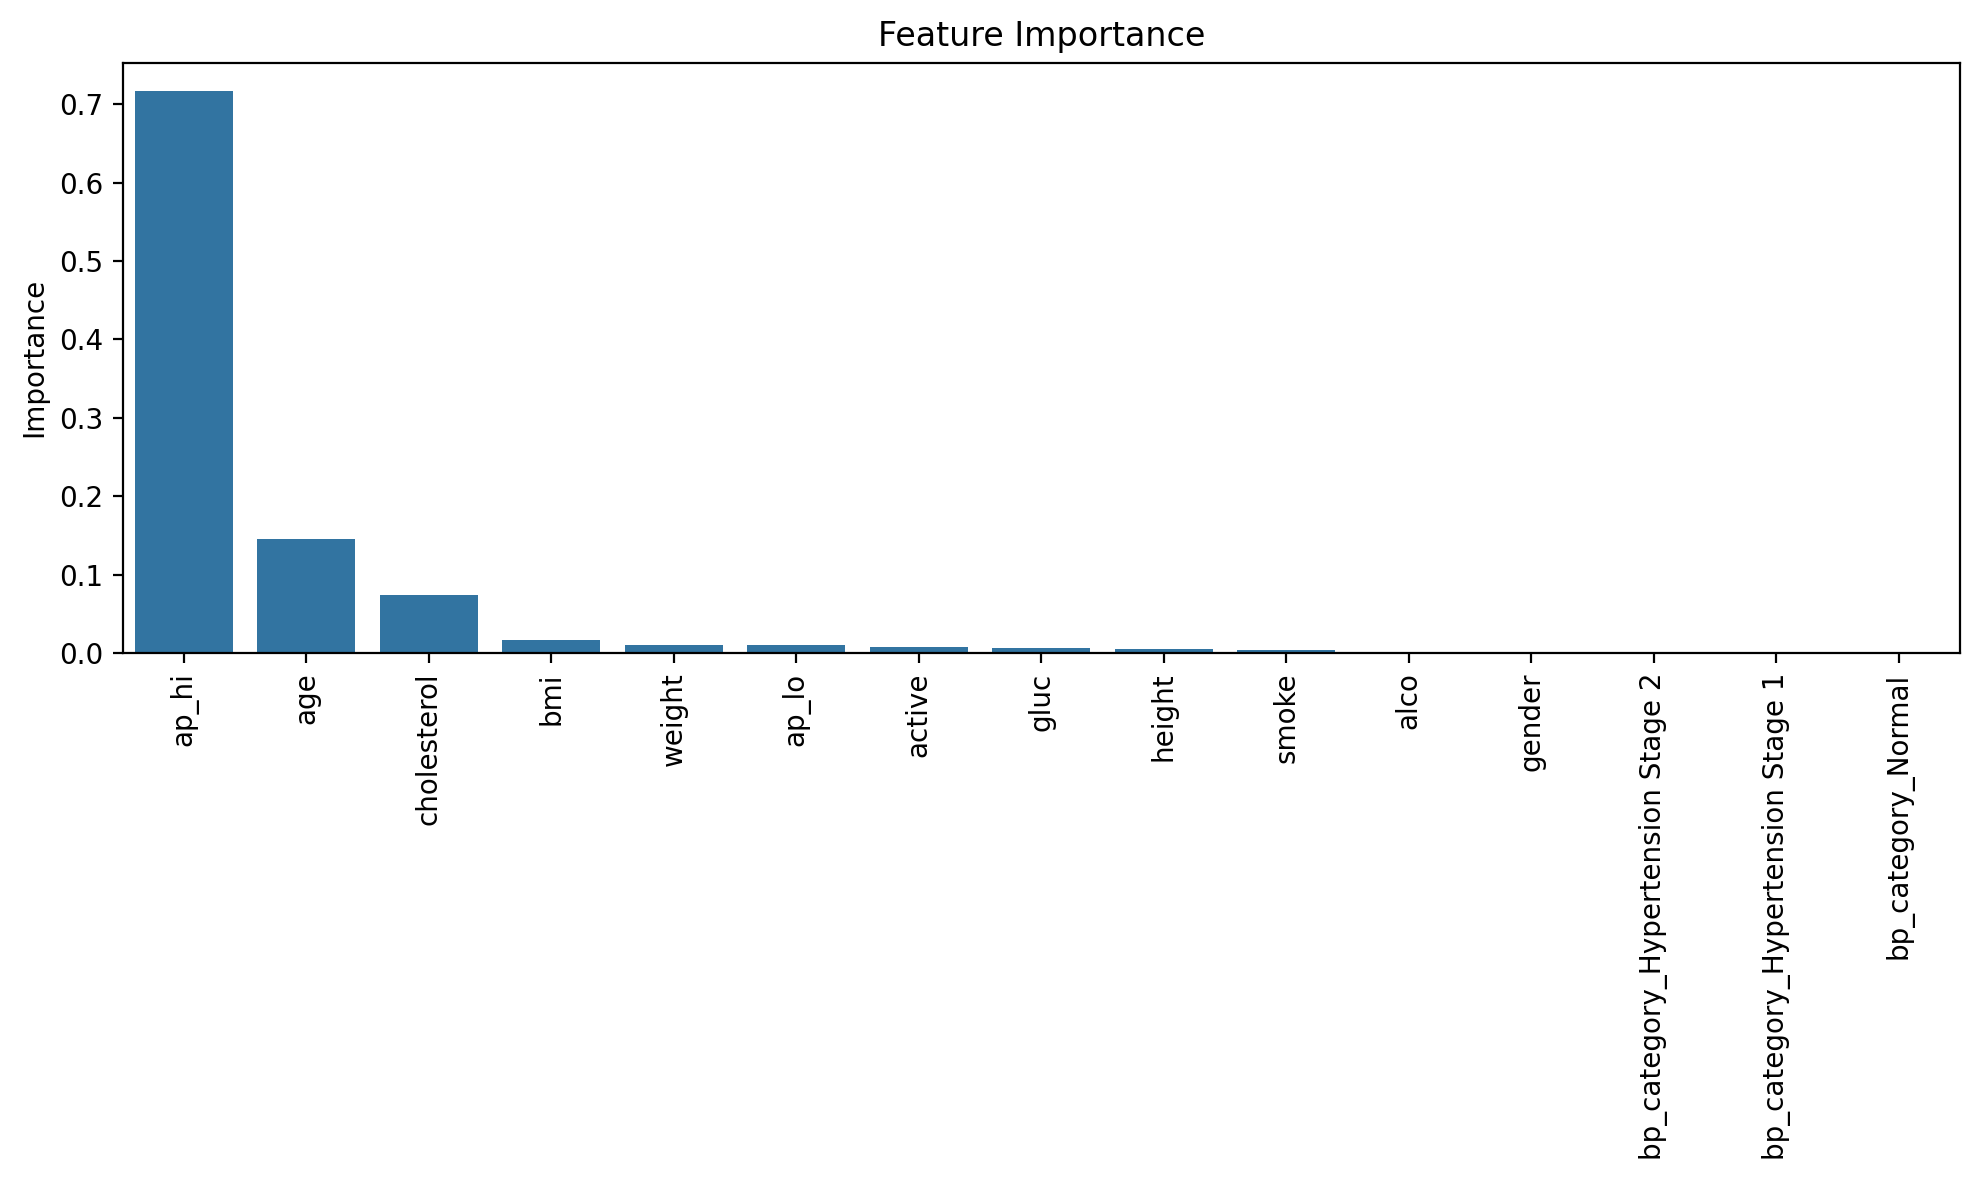

In [163]:
plot_tree_feature_importance(gbc_grid.best_estimator_, X_train.columns)

After hyperparameter tuning, the feature importances were virtually unchanged. ap_hi continues to be the top predictor by a very wide margin, with features like age and cholesterol following, even with much smaller contributions. Again, the trend of lifestyle features, like active, gluc, and smoke, contributing minimally continues. Feature distribution remains to be highly skewed toward a few dominant features. Again, this potentially could improve efficiency, but also might risk underfitting some of the more nuanced patterns.

Let's go ahead and save the feature importances. Afterwards, we'll see the model's varying performance based on the number of n_estimators.

In [164]:
export_tree_feature_importances(gbc_grid.best_estimator_, X_train.columns, 'gradient_boosting_tuned')

Let's take a look at how the Gradient Boosting model's performance is affected by increasing the number of estimators. We'll keep the same hyperparameters that GridSearchCV selected, except for n_estimators, which we will be varying and measuring the performance of.

In [83]:
gbc_estimator_error_rates = []

for n in range(10, 201, 10):
    gbc_test = GradientBoostingClassifier(n_estimators=n, learning_rate=0.05, max_depth=4)
    gbc_test.fit(X_train, y_train)
    gbc_test_preds = gbc_test.predict(X_test)
    errors = 1 - accuracy_score(y_test, gbc_test_preds)
    gbc_estimator_error_rates.append(errors)

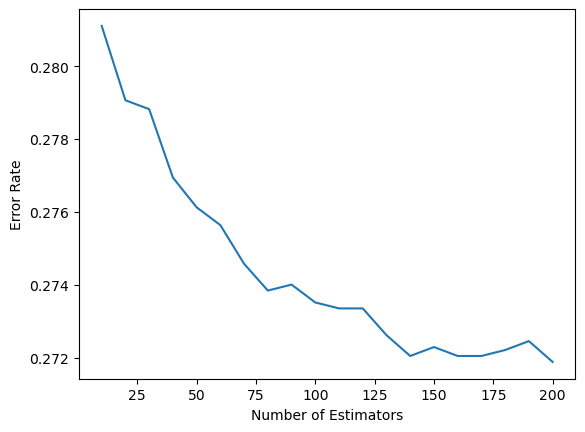

In [84]:
plt.plot(range(10, 201, 10),gbc_estimator_error_rates)
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate');

We see that between 10 to around 100 estimators, there is a clear drop in error, indicates that performance is significantly improved early on by more boosting rounds. Beyond that at around 150, the curve starts to flatten, suggesting more diminishing returns and a risk of overfitting if it's continued. Around 150 estimators is an ideal upper bound, which is what was outputted by GridSearchCV.


Overall, the tree-based models (Random Forest and Boosted Trees) achieved near-similar accuracy to our earlier models. We will consolidate results and outputs for each of the models in the next notebook, cardiovascular_disease_model_comparison.